# Fruit Image Classification

Image classification is the task of assigning a label or class to an entire image. Images are expected to have only one class for each image. Image classification models take an image as input and return a prediction about which class the image belongs to.

# Setup

Import Tensorflow and necessay libraries:

In [1]:
import tensorflow as tf       #
import numpy as np            #
import PIL                    #
import matplotlib.pyplot as plt #

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Download and explore the dataset

In [2]:
import pathlib

dataset_url = "https://drive.google.com/uc?export=download&id=1cOtq27eM3GiTGjfMOmk4iZ09CMArErDL"
data_dir = tf.keras.utils.get_file('Fruit.zip', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

24


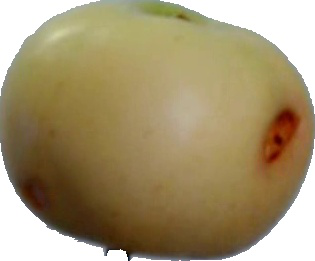

In [4]:
apples = list(data_dir.glob('apples/*'))
PIL.Image.open(str(apples[0]))





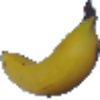

In [5]:
bananas = list(data_dir.glob('bananas/*'))
PIL.Image.open(str(bananas[0]))


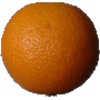

In [6]:

orange = list(data_dir.glob('orange/*'))
PIL.Image.open(str(orange[0]))

# Load data using a Keras utility

Next, load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code.

# Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24 files belonging to 3 classes.
Using 20 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24 files belonging to 3 classes.
Using 4 files for validation.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [10]:
class_names = train_ds.class_names
print(class_names)

['apples', 'bananas', 'orange']


# Visualize the data

Here are the first nine images from the training dataset:

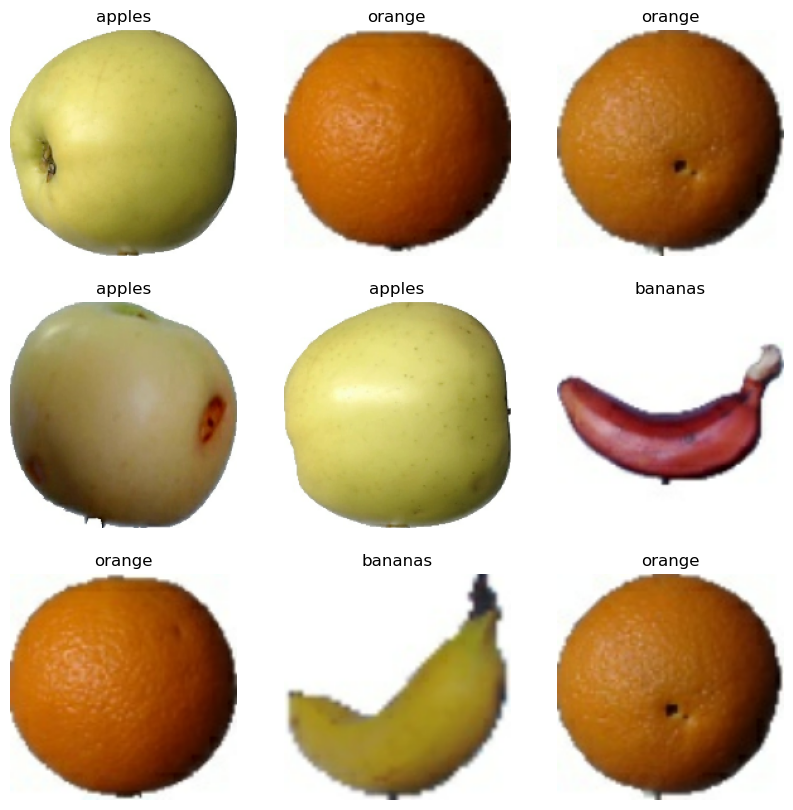

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras Model.fit method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(20, 180, 180, 3)
(20,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

# Configure the dataset for performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [14]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map:

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.04178225 1.0


# A basic Keras model

Create the model

In [16]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compile the model

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model summary

View all the layers of the network using the Keras Model.summary method:

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Train the model

Train the model for 10 epochs with the Keras Model.fit method:

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.0995 - accuracy: 0.5000 - val_loss: 4.2893 - val_accuracy: 0.2500
Epoch 2/10
1/1 [==============================] - 1s 595ms/step - loss: 3.3116 - accuracy: 0.4000 - val_loss: 1.0815 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 1s 603ms/step - loss: 0.8019 - accuracy: 0.7000 - val_loss: 1.0851 - val_accuracy: 0.7500
Epoch 4/10
1/1 [==============================] - 1s 628ms/step - loss: 1.2627 - accuracy: 0.6000 - val_loss: 0.8968 - val_accuracy: 0.7500
Epoch 5/10
1/1 [==============================] - 1s 623ms/step - loss: 1.0602 - accuracy: 0.6000 - val_loss: 0.7082 - val_accuracy: 0.7500
Epoch 6/10
1/1 [==============================] - 1s 601ms/step - loss: 0.6951 - accuracy: 0.6000 - val_loss: 0.6367 - val_accuracy: 0.7500
Epoch 7/10
1/1 [==============================] - 1s 629ms/step - loss: 0.4878 - accuracy: 0.8500 - val_loss: 0.7165 - val_accuracy: 0.5000
Epoch 8/10
1/1 [=======

# Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

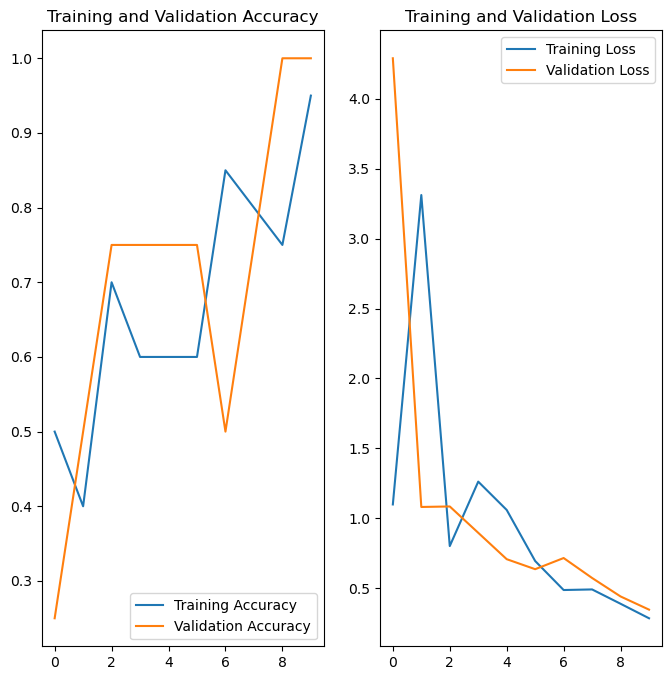

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Overfitting

# Data augmentation

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

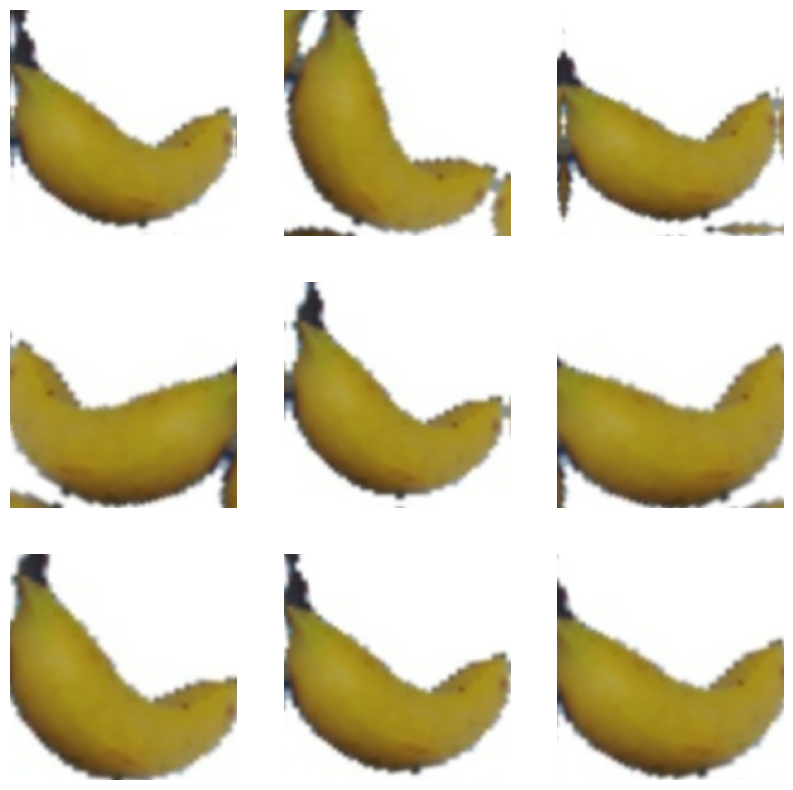

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

# Dropout

In [23]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

# Compile and train the model

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [25]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
1/1 [==============================] - 3s 3s/step - loss: 1.1783 - accuracy: 0.3000 - val_loss: 2.4748 - val_accuracy: 0.2500
Epoch 2/15
1/1 [==============================] - 1s 687ms/step - loss: 1.9477 - accuracy: 0.4000 - val_loss: 0.9263 - val_accuracy: 0.5000
Epoch 3/15
1/1 [==============================] - 1s 688ms/step - loss: 1.1552 - accuracy: 0.3000 - val_loss: 0.9926 - val_accuracy: 0.2500
Epoch 4/15
1/1 [==============================] - 1s 811ms/step - loss: 0.9335 - accuracy: 0.6000 - val_loss: 1.0635 - val_accuracy: 0.2500
Epoch 5/15
1/1 [==============================] - 1s 774ms/step - loss: 0.8676 - accuracy: 0.6000 - val_loss: 0.9038 - val_accuracy: 0.5000
Epoch 6/15
1/1 [==============================] - 1s 758ms/step - loss: 0.7242 - accuracy: 0.7000 - val_loss: 0.7247 - val_accuracy: 0.5000
Epoch 7/15
1/1 [==============================] - 1s 739ms/step - loss: 0.5717 - accuracy: 0.7000 - val_loss: 0.5468 - val_accuracy: 1.0000
Epoch 8/15
1/1 [=======

# Visualize training results

After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:

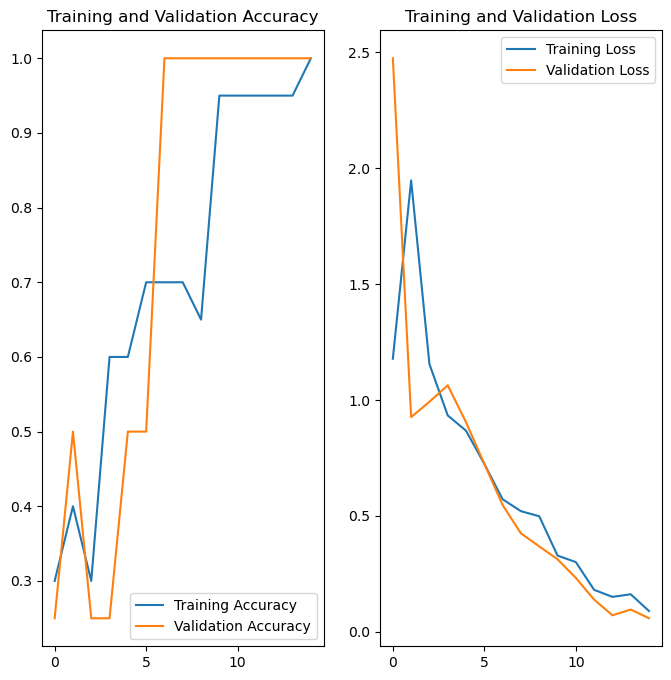

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [28]:
apples_url = "https://drive.google.com/uc?export=download&id=1jZQprA22gwIZN3GHLm7McHI3GoDtKQTQ"
apples_path = tf.keras.utils.get_file('Red_apples', origin=apples_url)

img = tf.keras.utils.load_img(
    apples_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 37ms/step
This image most likely belongs to apples with a 97.13 percent confidence.


In [29]:
banana_url = "https://drive.google.com/uc?export=download&id=15eAfw3a2BhfvPLlP3E-kupZWb7fGDnLi"
banana_path = tf.keras.utils.get_file('Red_apples', origin=banana_url)

img = tf.keras.utils.load_img(
    banana_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 34ms/step
This image most likely belongs to apples with a 97.13 percent confidence.


# Save model

In [30]:
model.save("model.keras")

# Load Model for prediction

We don't need to run all code for prediction.

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
import numpy as np
from PIL import Image
import requests
from io import BytesIO

In [6]:
loaded_model = keras.models.load_model('model.keras')

In [13]:
target_width = 180  # Replace with the actual target width of your model
target_height = 180  # Replace with the actual target height of your model

# Load and preprocess the image from URL
img_url = "https://drive.google.com/uc?export=download&id=15eAfw3a2BhfvPLlP3E-kupZWb7fGDnLi"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
img = img.resize((target_width, target_height))  # Resize to match model's input shape
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

class_labels = ["apple", "banana", "orange"]  # Replace with your actual class labels

predictions = loaded_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_labels[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 35ms/step
This image most likely belongs to orange with a 97.59 percent confidence.
